In [1]:
import torch
import torch.nn as nn
from utils.seq_data_loader import LoanSimDataset, collate_fn
from torch.utils.data import DataLoader
import numpy as np
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Device setup
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
scale_columns = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
]

features = [
    "action_num_actual",
    "gender",
    "age",
    "amount",
    "num_loan",
    "duration",
    "year_ratio",
    "diff_city",
    "marriage",
    "kids",
    "month_in",
    "housing",
    "edu",
    "motivation",
    "installment",
    "installment_timestep",
    "state_cum_overduelength",
    "remaining_debt",
    "state_capital",
    "state_interests",
    "state_penalty",
]

# Section 1: Prediction of the Recovery Rate

In [4]:
recovery_targets = [
    # "y_installment",
    # "y_installment_timestep",
    # "y_state_cum_overduelength",
    # "y_remaining_debt",
    # "y_state_capital",
    # "y_state_interests",
    # "y_state_penalty",
    # "installment_done",
    # "loan_done",
    "recovery_rate_weighted",
]

In [5]:
recovery_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=recovery_targets,
    group="train",
)


# use the test data as validation data
recovery_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=recovery_targets,
    group="test",  # read the test data
)

recovery_train_dataloader = DataLoader(
    recovery_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


recovery_val_dataloader = DataLoader(
    recovery_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [6]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(recovery_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100

# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [7]:
from models.lstm_recovery_1 import LSTMModel as LSTMModel1

model = LSTMModel1(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)


criterion = nn.MSELoss()  # regression question, so use MSE as the Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.to(device)
recovery_train_losses = []
recovery_val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in recovery_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    recovery_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(recovery_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in recovery_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    recovery_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(recovery_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # save the best model
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.00362295, Val Loss: 0.00250108
Epoch 2/100, Train Loss: 0.00234883, Val Loss: 0.00231896
Epoch 3/100, Train Loss: 0.00226995, Val Loss: 0.00233516
Epoch 4/100, Train Loss: 0.00222851, Val Loss: 0.00230572
Epoch 5/100, Train Loss: 0.00222122, Val Loss: 0.00228175
Epoch 6/100, Train Loss: 0.00220894, Val Loss: 0.00227962
Epoch 7/100, Train Loss: 0.00223169, Val Loss: 0.00225148
Epoch 8/100, Train Loss: 0.00219173, Val Loss: 0.00222101
Epoch 9/100, Train Loss: 0.00218888, Val Loss: 0.00225087
Epoch 10/100, Train Loss: 0.00218790, Val Loss: 0.00225588
Epoch 11/100, Train Loss: 0.00215131, Val Loss: 0.00223631
Epoch 12/100, Train Loss: 0.00215219, Val Loss: 0.00220718
Epoch 13/100, Train Loss: 0.00214866, Val Loss: 0.00225378
Epoch 14/100, Train Loss: 0.00214799, Val Loss: 0.00228775
Epoch 15/100, Train Loss: 0.00216153, Val Loss: 0.00225022
Epoch 16/100, Train Loss: 0.00211967, Val Loss: 0.00226551
Epoch 17/100, Train Loss: 0.00213828, Val Loss: 0.00224417
Epoch 

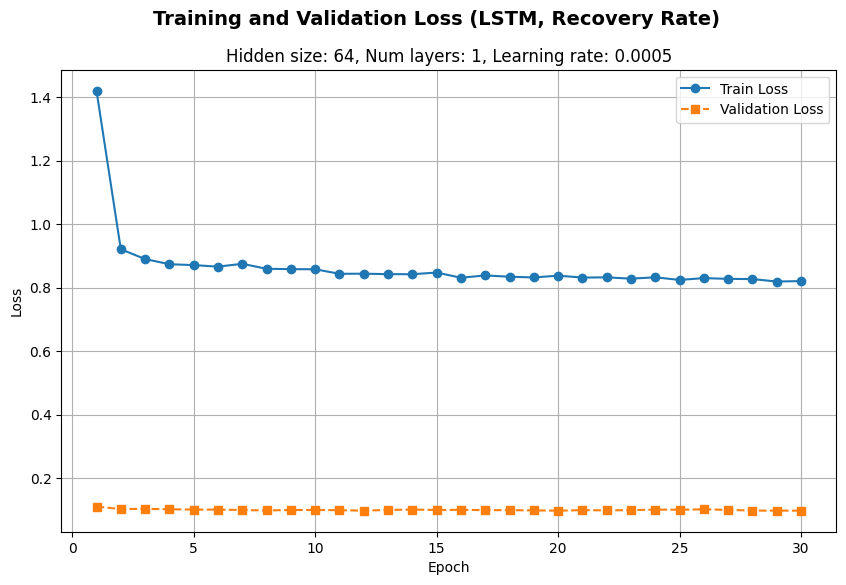

In [9]:
epochs = range(1, len(recovery_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, recovery_train_losses, label="Train Loss", marker="o", linestyle="-")
plt.plot(epochs, recovery_val_losses, label="Validation Loss", marker="s", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Recovery Rate)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

# Section 2: Prediction of the Next State

In [10]:
state_targets = [
    "y_installment",
    "y_installment_timestep",
    "y_state_cum_overduelength",
    "y_remaining_debt",
    "y_state_capital",
    "y_state_interests",
    "y_state_penalty",
    # "installment_done",
    # "loan_done",
    # "recovery_rate_weighted",
]

In [11]:
state_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=state_targets,
    group="train",
)


# use the test data as validation data
state_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=state_targets,
    group="test",  # read the test data
)

state_train_dataloader = DataLoader(
    state_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


state_val_dataloader = DataLoader(
    state_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [12]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(state_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100
# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [13]:
from models.lstm_state_1 import LSTMModel as LSTMModel2


model = LSTMModel2(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)


criterion = nn.MSELoss()  # regression question, so use MSE as the Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
model.to(device)


state_train_losses = []
state_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in state_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    state_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(state_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in state_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    state_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(state_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # torch.save(model.state_dict(), "best_model.pth")  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.22959328, Val Loss: 0.13936229
Epoch 2/100, Train Loss: 0.10749392, Val Loss: 0.07619512
Epoch 3/100, Train Loss: 0.06639011, Val Loss: 0.05445008
Epoch 4/100, Train Loss: 0.05122181, Val Loss: 0.04519592
Epoch 5/100, Train Loss: 0.04378416, Val Loss: 0.04107154
Epoch 6/100, Train Loss: 0.04088506, Val Loss: 0.03725038
Epoch 7/100, Train Loss: 0.03761589, Val Loss: 0.03624366
Epoch 8/100, Train Loss: 0.03587746, Val Loss: 0.03416952
Epoch 9/100, Train Loss: 0.03468584, Val Loss: 0.03255667
Epoch 10/100, Train Loss: 0.03375287, Val Loss: 0.03276964
Epoch 11/100, Train Loss: 0.03329379, Val Loss: 0.03116451
Epoch 12/100, Train Loss: 0.03286329, Val Loss: 0.03098412
Epoch 13/100, Train Loss: 0.03206916, Val Loss: 0.03166867
Epoch 14/100, Train Loss: 0.03163505, Val Loss: 0.03032686
Epoch 15/100, Train Loss: 0.03136003, Val Loss: 0.03073009
Epoch 16/100, Train Loss: 0.03091208, Val Loss: 0.03006365
Epoch 17/100, Train Loss: 0.03079491, Val Loss: 0.03024263
Epoch 

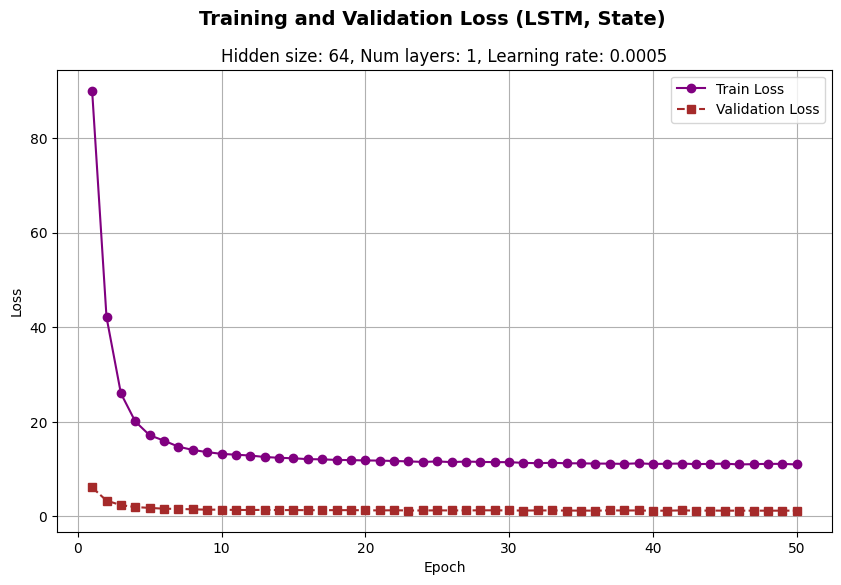

In [15]:
epochs = range(1, len(state_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(
    epochs,
    state_train_losses,
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="purple",
)
plt.plot(
    epochs,
    state_val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="brown",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, State)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

# Section 3: Prediction of Installment Done

In [16]:
ins_targets = [
    # "y_installment",
    # "y_installment_timestep",
    # "y_state_cum_overduelength",
    # "y_remaining_debt",
    # "y_state_capital",
    # "y_state_interests",
    # "y_state_penalty",
    "installment_done",
    # "loan_done",
    # "recovery_rate_weighted",
]

In [17]:
ins_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=ins_targets,
    group="train",
)


# use the test data as validation data
ins_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=ins_targets,
    group="test",  # read the test data
)

ins_train_dataloader = DataLoader(
    ins_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


ins_val_dataloader = DataLoader(
    ins_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [18]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(ins_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100
# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [19]:
from models.lstm_ins_1 import LSTMModel as LSTMModel3

model = LSTMModel3(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)

# boolean classification, so use BCE as the Loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
model.to(device)


ins_train_losses = []
ins_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in ins_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    ins_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(ins_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in ins_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    ins_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(ins_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # torch.save(model.state_dict(), "best_model.pth")  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.55516378, Val Loss: 0.45221256
Epoch 2/100, Train Loss: 0.40358720, Val Loss: 0.36828422
Epoch 3/100, Train Loss: 0.33777266, Val Loss: 0.30904317
Epoch 4/100, Train Loss: 0.28833919, Val Loss: 0.26675284
Epoch 5/100, Train Loss: 0.25125583, Val Loss: 0.23580423
Epoch 6/100, Train Loss: 0.22393018, Val Loss: 0.21146257
Epoch 7/100, Train Loss: 0.20113907, Val Loss: 0.19129820
Epoch 8/100, Train Loss: 0.18201281, Val Loss: 0.17367890
Epoch 9/100, Train Loss: 0.16628406, Val Loss: 0.15948585
Epoch 10/100, Train Loss: 0.15218027, Val Loss: 0.14739615
Epoch 11/100, Train Loss: 0.13996775, Val Loss: 0.13530070
Epoch 12/100, Train Loss: 0.12912136, Val Loss: 0.12619565
Epoch 13/100, Train Loss: 0.11952135, Val Loss: 0.11743862
Epoch 14/100, Train Loss: 0.11133578, Val Loss: 0.10933344
Epoch 15/100, Train Loss: 0.10429184, Val Loss: 0.10292616
Epoch 16/100, Train Loss: 0.09767767, Val Loss: 0.09690250
Epoch 17/100, Train Loss: 0.09241854, Val Loss: 0.09309108
Epoch 

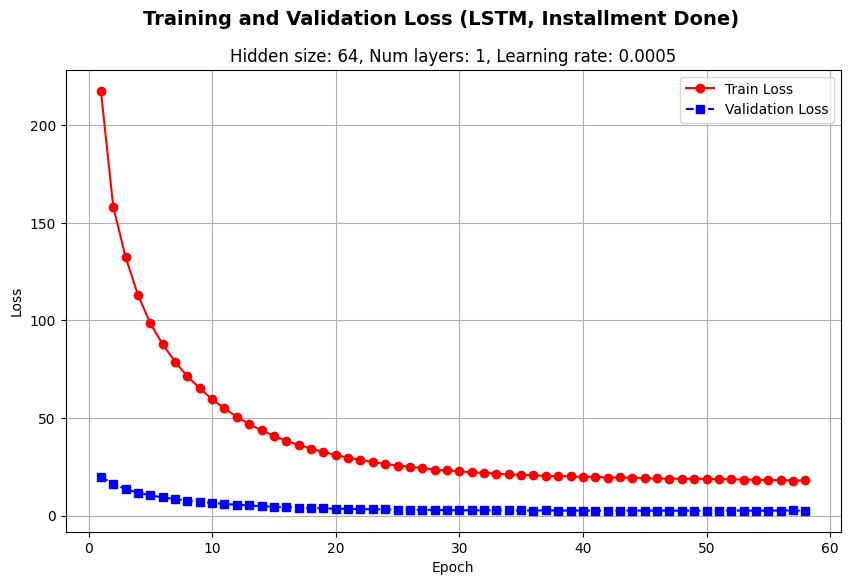

In [21]:
epochs = range(1, len(ins_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(
    epochs, ins_train_losses, label="Train Loss", marker="o", linestyle="-", color="red"
)
plt.plot(
    epochs,
    ins_val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="blue",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle(
    "Training and Validation Loss (LSTM, Installment Done)", weight="bold", size=14
)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

# Section 4: Prediction of Loan Done

In [22]:
loan_targets = [
    # "y_installment",
    # "y_installment_timestep",
    # "y_state_cum_overduelength",
    # "y_remaining_debt",
    # "y_state_capital",
    # "y_state_interests",
    # "y_state_penalty",
    # "installment_done",
    "loan_done",
    # "recovery_rate_weighted",
]

In [23]:
loan_train_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=loan_targets,
    group="train",
)


# use the test data as validation data
loan_val_dataset = LoanSimDataset(
    csv_file_path="./Res/simulator_data.csv",
    scale_columns=scale_columns,
    feature_columns=features,
    target_columns=loan_targets,
    group="test",  # read the test data
)

loan_train_dataloader = DataLoader(
    loan_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)


loan_val_dataloader = DataLoader(
    loan_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)

In [24]:
# initialize the model, loss function and optimizer
input_size = len(features)  # num of features
hidden_size = 64  # size of hidden layer state
output_size = len(loan_targets)  # number of targets
num_layers = 1  # number of layers
learning_rate = 0.0005
num_epochs = 100
# Paras for Early Stopping
patience = 10  # the number of epochs to wait before stopping training
best_val_loss = np.inf  # initialize the best validation loss
counter = 0  # initialize the counter

In [25]:
from models.lstm_loan_1 import LSTMModel as LSTMModel4

model = LSTMModel4(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)

# boolean classification, so use BCE as the Loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
model.to(device)


loan_train_losses = []
loan_val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets, lengths in loan_train_dataloader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loan_train_losses.append(running_loss)
    avg_train_loss = running_loss / len(loan_train_dataloader)

    # calculate validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, lengths in loan_val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    loan_val_losses.append(val_loss)
    avg_val_loss = val_loss / len(loan_val_dataloader)
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.8f}, Val Loss: {avg_val_loss:.8f}"
    )

    # Logic of Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # rest the counter
        # torch.save(model.state_dict(), "best_model.pth")  # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered!")
            break  # stop training the model if early stopping is triggered

Epoch 1/100, Train Loss: 0.50104449, Val Loss: 0.41690517
Epoch 2/100, Train Loss: 0.38529406, Val Loss: 0.34951709
Epoch 3/100, Train Loss: 0.32816445, Val Loss: 0.29370327
Epoch 4/100, Train Loss: 0.28033298, Val Loss: 0.25954286
Epoch 5/100, Train Loss: 0.24573193, Val Loss: 0.22424124
Epoch 6/100, Train Loss: 0.21737585, Val Loss: 0.20147146
Epoch 7/100, Train Loss: 0.19076561, Val Loss: 0.17912507
Epoch 8/100, Train Loss: 0.16876295, Val Loss: 0.15852678
Epoch 9/100, Train Loss: 0.14917022, Val Loss: 0.13832449
Epoch 10/100, Train Loss: 0.13214798, Val Loss: 0.12293327
Epoch 11/100, Train Loss: 0.11727954, Val Loss: 0.10933186
Epoch 12/100, Train Loss: 0.10442163, Val Loss: 0.09699836
Epoch 13/100, Train Loss: 0.09285347, Val Loss: 0.08600202
Epoch 14/100, Train Loss: 0.08344273, Val Loss: 0.07747669
Epoch 15/100, Train Loss: 0.07426991, Val Loss: 0.06982066
Epoch 16/100, Train Loss: 0.06642381, Val Loss: 0.06239977
Epoch 17/100, Train Loss: 0.05951776, Val Loss: 0.05655263
Epoch 

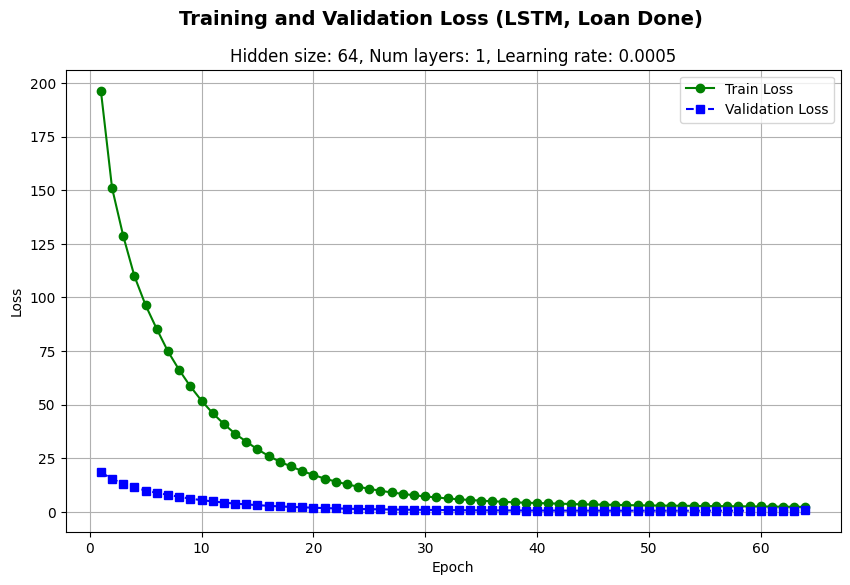

In [27]:
epochs = range(1, len(loan_train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(
    epochs,
    loan_train_losses,
    label="Train Loss",
    marker="o",
    linestyle="-",
    color="Green",
)
plt.plot(
    epochs,
    loan_val_losses,
    label="Validation Loss",
    marker="s",
    linestyle="--",
    color="blue",
)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# add model parameters to the subtitle
plt.suptitle("Training and Validation Loss (LSTM, Loan Done)", weight="bold", size=14)
plt.title(
    f"Hidden size: {hidden_size}, Num layers: {num_layers}, Learning rate: {learning_rate}"
)

plt.legend()
plt.grid(True)

# save the plot
# plt.savefig("training_validation_loss_lstm.png")
plt.show()

In [49]:
import numpy as np

all_labels = []
all_preds = []

threshold = 0.5  # threshold for the prediction

with torch.no_grad():
    for inputs, targets, lengths in loan_val_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, lengths)

        # calculate the predictions
        # preds = torch.sigmoid(outputs.squeeze(-1))  # map to 0-1
        preds = outputs.squeeze(-1)
        preds = (preds >= threshold).long()  # change to 0/1

        # enumerate over the batch
        for i in range(len(lengths)):
            seq_len = lengths[i].item()  # true length of the sequence
            all_labels.extend(targets[i, :seq_len].cpu().tolist())  # save scalar
            all_preds.extend(preds[i, :seq_len].cpu().tolist())  # save scalar

# transform to numpy array
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

all_labels = all_labels.squeeze()
all_preds = all_preds.squeeze()
print(f"all_labels shape: {all_labels.shape}")  # make sure it is one-dimensional
print(f"all_preds shape: {all_preds.shape}")  # make sure it is one-dimensional

all_labels shape: (19789,)
all_preds shape: (19789,)


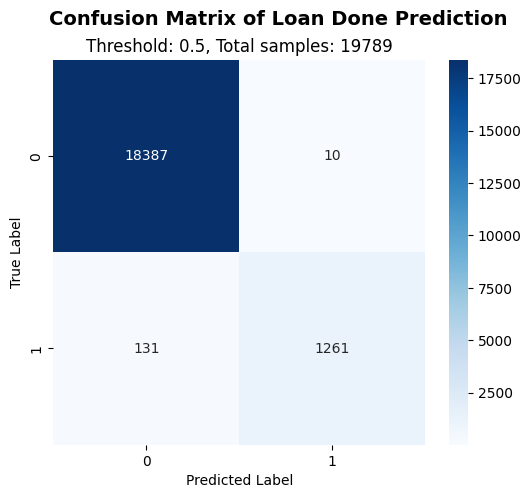

In [50]:
# compute the confusion matrix
cm = confusion_matrix(list(all_labels), list(all_preds))

# draw the heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["0", "1"],
    yticklabels=["0", "1"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.suptitle("Confusion Matrix of Loan Done Prediction", weight="bold", size=14)
plt.title(f"Threshold: {threshold}, Total samples: {len(all_labels)}")

plt.show()